In [1]:
#Load Nescessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import math

from sklearn.metrics import mean_squared_error
import statsmodels.tsa.statespace.sarimax


### Data Pre Processing

In [2]:
#Import Historical Eth Prices

eth_ts = pd.read_csv('ETH.csv')

In [3]:
#Create Date Time Index out of Unix Epoch Time Format

eth_ts['time'] = pd.to_datetime(eth_ts['time'], unit='s')

eth_ts.set_index('time', inplace=True)

#Preview Results

eth_ts.head()

,open,high,low,close,Volume,Volume MA,Plot,Plot.1,Plot.2,52 Week High,...,Plot.5,Plot.6,Plot.7,Plot.8,EMA Divergence,Min,Max,-Min,-Max,Plot.9
time,,,,,,,,,,,,,,,,,,,,,
2019-10-10,193.26,194.85,187.29,191.79,86674.15560,108015.394811,0,NaN,NaN,NaN,...,NaN,210.87390,206.5159,182.802370,NaN,1.75,3.5,NaN,NaN,191.79
2019-10-11,191.86,197.93,179.23,180.84,121748.85811,110812.895238,0,NaN,NaN,NaN,...,NaN,211.11305,205.3064,182.615478,NaN,1.75,3.5,NaN,NaN,180.84
2019-10-12,180.94,184.87,177.27,179.86,57840.91643,110464.225637,0,NaN,NaN,NaN,...,NaN,211.34595,204.2770,182.353051,NaN,1.75,3.5,NaN,NaN,179.86
2019-10-13,179.76,184.75,178.63,181.18,51204.18219,108389.184075,0,NaN,NaN,NaN,...,NaN,211.55645,203.2088,182.241332,NaN,1.75,3.5,NaN,NaN,181.18
2019-10-14,181.12,187.91,180.52,186.85,60870.12963,91161.342433,0,NaN,NaN,NaN,...,NaN,211.80340,202.2016,182.680253,NaN,1.75,3.5,NaN,NaN,186.85


### Time Series Preview and Analysis

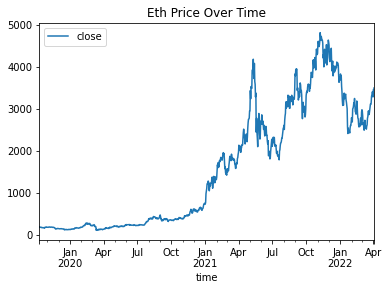

In [4]:
#Quick Preview of Time Series

eth_ts[['close']].plot()
plt.title('Eth Price Over Time');

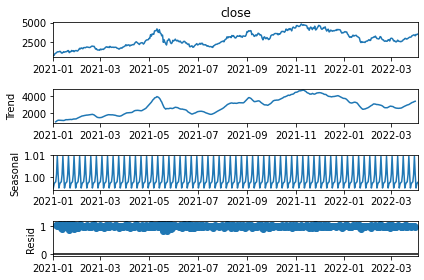

In [5]:
#Decompose Time Series 2021 onwards

eth_2021_onwards = eth_ts['2021':]

result = seasonal_decompose(eth_2021_onwards['close'], model='multiplicative')

result.plot();

### Ascertaining Optimal Combinations for Model

In [6]:
#Establish Train & Test Sets

eth_close_ts = eth_ts['close']

X_train = eth_close_ts[:-14]
y_train = eth_close_ts[-14:-7]
y_test = eth_close_ts[-7:]

In [7]:
#Get pdq and PDQS iterations:

# Define the p, d and q parameters to take any value between 0 and 2

p = d = q = range(0,3,1)

# Generate all different combinations of p, q and q triplets

pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets (use 12 for frequency)

pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [8]:
# #Get best iterations

# best_iterations = []

# for combo in pdq:
#     for seasonal_combo in pdqs:
#         final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
#                                                                  order = combo,
#                                                                  seasonal_order = seasonal_combo,
#                                                                  enforce_stationarity = False,
#                                                                  enforce_invertibility = False)

#         final_model_fit = final_model.fit()

#         preds = final_model_fit.get_forecast(steps = 7)

#         preds = preds.summary_frame()[['mean']]

#         mse = mean_squared_error(preds, y_train)
        
#         rmse = math.sqrt(mse)
        
#         best_iterations.append([combo, seasonal_combo, mse, rmse])
        
#         print(combo, seasonal_combo)

In [9]:
# #Create a Best Iterations Dataframe:

# best_iterations_df = pd.DataFrame(best_iterations, columns = ['pdq', 'PDQS', 'MSE', 'RMSE'])

# #Export Best Iterations to Excel for Record Keeping

# best_iterations_df.to_excel('Best Iterations.xlsx')

In [10]:
#Load Best Iterations:

best_iterations_df = pd.read_excel('Best Iterations.xlsx')

In [11]:
#Isolating Top 5 Iterations

top_5_iterations = best_iterations_df.sort_values(by='RMSE').head(5)

#Preview Top 5 Iterations

top_5_iterations

,Unnamed: 0,pdq,PDQS,MSE,RMSE
719,719,"(2, 2, 2)","(1, 2, 2, 7)",7277.375577,85.307535
412,412,"(1, 2, 0)","(0, 2, 1, 7)",9814.109643,99.066188
408,408,"(1, 2, 0)","(0, 1, 0, 7)",10023.793097,100.118895
354,354,"(1, 1, 1)","(0, 1, 0, 7)",10578.742520,102.853014
597,597,"(2, 1, 1)","(0, 1, 0, 7)",10645.765167,103.178317


In [27]:
#Validate Results With Test Set

test_rmse_list = []

for item in range(0,5,1):
    
    combo = top_5_iterations['pdq'].iloc[item].replace("(","").replace(")","")
    seasonal_combo = top_5_iterations['PDQS'].iloc[item].replace("(","").replace(")","")
    combo = tuple(map(int, combo.split(', ')))
    seasonal_combo = tuple(map(int, seasonal_combo.split(', ')))
    
    final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                                             order = combo,
                                                             seasonal_order = seasonal_combo,
                                                             enforce_stationarity = False,
                                                             enforce_invertibility = False)

    final_model_fit = final_model.fit()
    preds = final_model_fit.get_forecast(steps = 14)
    preds = preds.summary_frame()[['mean']]
    test_preds = preds[7:]
    test_rmse = math.sqrt(mean_squared_error(y_test, test_preds))
    test_rmse
    test_rmse_list.append(test_rmse)

top_5_iterations['TEST RMSE'] = test_rmse_list

/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.75212D+00    |proj g|=  1.53117D+00

At iterate    5    f=  6.46373D+00    |proj g|=  2.08898D-01

At iterate   10    f=  6.43822D+00    |proj g|=  7.90096D-02

At iterate   15    f=  6.42683D+00    |proj g|=  5.33787D-02

At iterate   20    f=  6.40597D+00    |proj g|=  1.78240D-01

At iterate   25    f=  6.40014D+00    |proj g|=  2.27440D-02

At iterate   30    f=  6.39991D+00    |proj g|=  3.21284D-03

At iterate   35    f=  6.39973D+00    |proj g|=  1.62428D-02

At iterate   40    f=  6.39786D+00    |proj g|=  3.53201D-02

At iterate   45    f=  6.31363D+00    |proj g|=  1.11777D-01

At iterate   50    f=  6.28999D+00    |proj g|=  1.48833D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86512D+00    |proj g|=  6.37741D-01

At iterate    5    f=  6.68316D+00    |proj g|=  1.36627D-01

At iterate   10    f=  6.67759D+00    |proj g|=  2.00749D-03

At iterate   15    f=  6.67740D+00    |proj g|=  4.82275D-02

At iterate   20    f=  6.65628D+00    |proj g|=  3.55787D-01

At iterate   25    f=  6.47448D+00    |proj g|=  1.09271D-01

At iterate   30    f=  6.47318D+00    |proj g|=  4.58154D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.
/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  w

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.55346D+00    |proj g|=  7.62368D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   7.624D-06   6.553D+00
  F =   6.5534563857838792     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.3

In [28]:
#Select Top 3 Validated Models

top_3_iterations = top_5_iterations.sort_values(by='TEST RMSE').head(3)

#Preview Top 3 Models

top_3_iterations

,Unnamed: 0,pdq,PDQS,MSE,RMSE,TEST RMSE
719,719,"(2, 2, 2)","(1, 2, 2, 7)",7277.375577,85.307535,125.064833
354,354,"(1, 1, 1)","(0, 1, 0, 7)",10578.742520,102.853014,140.939128
597,597,"(2, 1, 1)","(0, 1, 0, 7)",10645.765167,103.178317,141.603164


In [41]:
#Train Final Model

combo = (1, 1, 1)
seasonal_combo = (0, 1, 0, 7)

final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                                         order = combo,
                                                         seasonal_order = seasonal_combo,
                                                         enforce_stationarity = False,
                                                         enforce_invertibility = False)

final_model_fit = final_model.fit(disp=False)

/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/angelogayanelo/opt/anaconda3/envs/phase4/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [42]:
final_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              close   No. Observations:                  893
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 7)   Log Likelihood               -5661.524
Date:                            Wed, 06 Apr 2022   AIC                          11329.047
Time:                                    00:51:20   BIC                          11343.397
Sample:                                10-10-2019   HQIC                         11334.534
                                     - 03-20-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8986      0.029    -30.999      0.000      -0.955      -0.842
ma.L1          0.8051      0.040     20.190      0.000       0.727       0.883
sigma2       2.17e+04    502.849     43.144      0.000    2.07e+04    2.27e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2191.65
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):             230.94   Skew:                            -0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
#Aggregate Actuals and Predictions into a Data Frame

pred_period = eth_ts['close'][-14:]

results_df = pd.DataFrame(pred_period)

results_df.columns=['ACTUALS']

#Get Predictions Per Model

for item in range(0,3,1):
    
    combo = top_5_iterations['pdq'].iloc[item].replace("(","").replace(")","")
    seasonal_combo = top_5_iterations['PDQS'].iloc[item].replace("(","").replace(")","")
    combo = tuple(map(int, combo.split(', ')))
    seasonal_combo = tuple(map(int, seasonal_combo.split(', ')))

    final_model = statsmodels.tsa.statespace.sarimax.SARIMAX(X_train,
                                                             order = top_3_iterations['pdq'].iloc[item],
                                                             seasonal_order = top_3_iterations['PDQS'].iloc[item],
                                                             enforce_stationarity = False,
                                                             enforce_invertibility = False)

    final_model_fit = final_model.fit()
    preds = final_model_fit.get_forecast(steps = 14)
    preds = preds.summary_frame()[['mean']]
    results_df[f'Model {item+1}'] = preds

ValueError: `order` argument must be an iterable with three elements.

In [ ]:
#View Predictions in a Table

results_df

In [ ]:
#Plot Results in Graph

results_df.plot()
plt.title('Estimated Ethereum Price Direction vs. Actuals');